In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sklearn as sk
from pandas.plotting import lag_plot

[*********************100%***********************]  1 of 1 completed


Coefficient: 0.022348183359926287
Intercept: 0.0017426465380892848
R2: 0.00


Price,Close,High,Low,Open,Volume,Close + 1,Target,High_2prev,Bull_FVG,Bull_FVG_Val,Low_2prev,Bear_FVG,Bear_FVG_Val,Both_FVG,Predictions,residuals
Date,,,,,,,,,,,,,,,,
1999-02-01,0.037008,0.037246,0.036291,0.036291,154704000,0.034143,-0.077418,0.038440,0,-0.000000,0.037843,1,-0.016128,-0.016128,0.001382,0.078801
1999-02-03,0.034859,0.035337,0.033426,0.033665,75120000,0.036769,0.054785,0.037246,0,-0.000000,0.036291,1,-0.027379,-0.027379,0.001131,-0.053655
1999-02-05,0.037843,0.038202,0.036411,0.037366,136848000,0.036530,-0.034693,0.035337,1,0.028394,0.033426,0,0.000000,0.028394,0.002377,0.037070
1999-02-10,0.034740,0.036053,0.034143,0.035097,148224000,0.037724,0.085904,0.038202,0,-0.000000,0.036530,1,-0.013750,-0.013750,0.001435,-0.084469
1999-02-12,0.039873,0.040112,0.038202,0.038202,109728000,0.040111,0.005978,0.036053,1,0.053898,0.034143,0,0.000000,0.053898,0.002947,-0.003031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-03,180.339996,186.270004,176.229996,186.240005,204019600,174.190002,-0.034102,194.490005,0,-0.000000,189.470001,1,-0.017744,-0.017744,0.001346,0.035448
2026-02-04,174.190002,179.580002,171.910004,179.460007,207014100,171.880005,-0.013261,190.300003,0,-0.000000,184.880005,1,-0.030427,-0.030427,0.001063,0.014324
2026-02-09,190.039993,193.660004,183.949997,184.259995,196387400,188.539993,-0.007893,176.820007,1,0.037518,171.029999,0,0.000000,0.037518,0.002581,0.010474


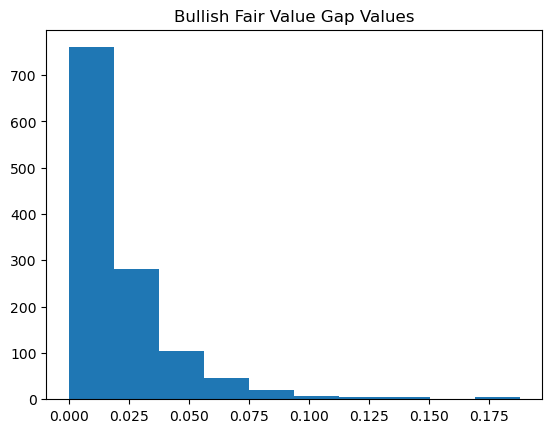

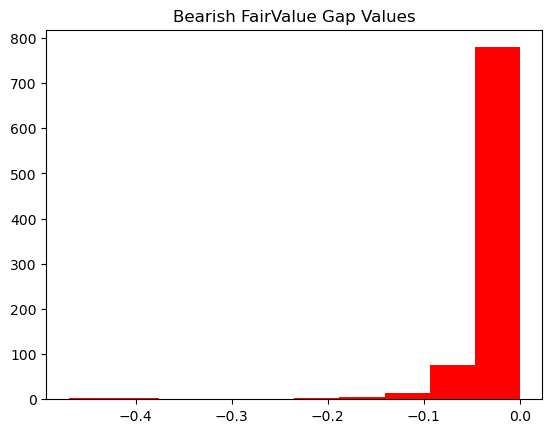

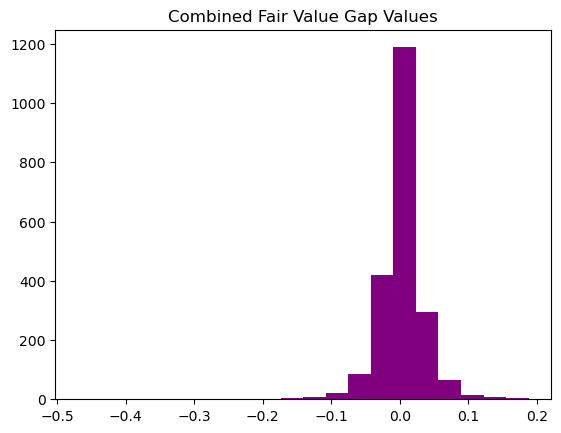

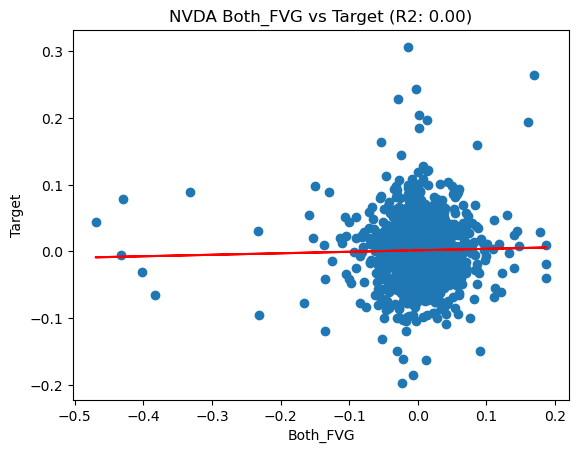

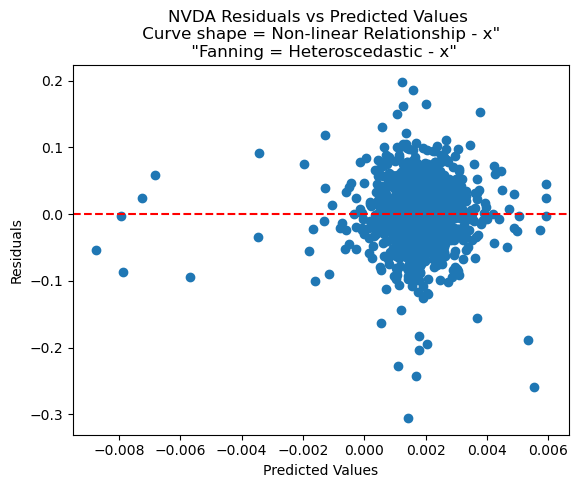

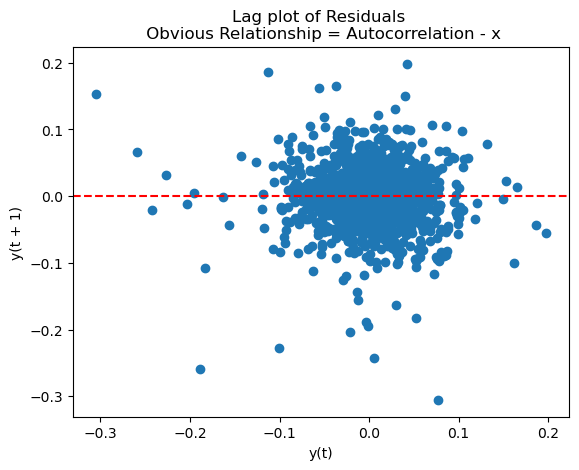

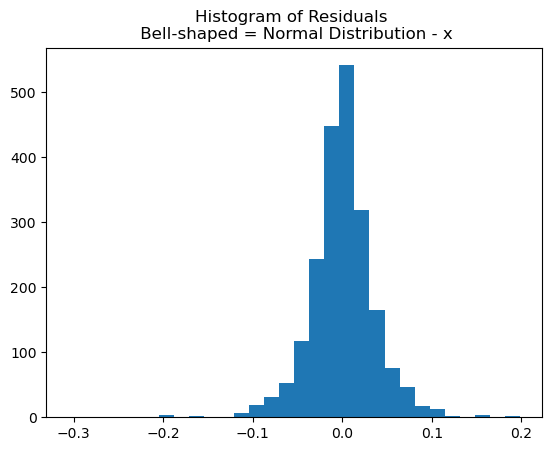

In [2]:
ticker = 'NVDA'
LOOKBACK = -10000
SHIFT = 1
STRATEGY='Both_FVG'

def get_data():
    df = yf.download(ticker, period = '40y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]

def add_target(df, shift=SHIFT):

    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    #what is the change in  close price SHIFT days from now?
    df['Target'] = ((df[f'Close + {shift}'] - df['Close']) / df['Close'])
    return df

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    fvg_subset = df[df['Bull_FVG_Val'] > 0]

    plt.figure()
    plt.hist(fvg_subset['Bull_FVG_Val'], bins=10)
    plt.title("Bullish Fair Value Gap Values")

    return df

def bear_fvg(df):
    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    fvg_subset = df[df['Bear_FVG_Val'] < 0]

    plt.figure()
    plt.hist(fvg_subset['Bear_FVG_Val'], bins=10, color='red')
    plt.title("Bearish FairValue Gap Values")

    return df

def prepare_dataframe_for_regression(df):
    df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
    df['Both_FVG'] = df['Bull_FVG_Val'] + df['Bear_FVG_Val']
    plt.figure()
    plt.hist(df['Both_FVG'], bins=20, color='purple')
    plt.title("Combined Fair Value Gap Values")
    return df

def generate_regression_output(df, feature=STRATEGY, target='Target'):
    
    subset = df[[feature,target]].dropna()

    # reshape for sklearn 
    x = subset[[feature]].dropna() #2d
    y = subset[target].dropna()  #1d

    model = sk.linear_model.LinearRegression()
    model.fit(x, y)

    # use the regression model to "predict" the target variable
    y_pred = model.predict(x)

    #what is the relationhip btw features and target?
    r2 = sk.metrics.r2_score(y, y_pred)

    # make coefficient variable
    coefficient = model.coef_[0]
    intercept = model.intercept_

    #coef, intercept, r2..... mse  later on
    print(f'Coefficient: {coefficient}')
    print(f'Intercept: {intercept}')
    print(f'R2: {r2:.2f}')

    #plot a relationship btw feature and target
    plt.figure()
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red', label='Regression Line')
    plt.xlabel(f'{feature}')
    plt.ylabel(f'{target}')
    plt.title(f'{ticker} {feature} vs {target} (R2: {r2:.2f})')

    return coefficient, intercept

def validate_regression_output(df, coef, intercept):
    # y = mx + c
    #info neccessary
    #test_linearity_homoscedasticity
    df['Predictions'] = df[STRATEGY] * coef + intercept
    df['residuals'] = df['Predictions'] - df['Target']

    #plot relationship
    plt.figure()
    plt.scatter(df['Predictions'], df['residuals'])
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{ticker} Residuals vs Predicted Values \n Curve shape = Non-linear Relationship - x" \n "Fanning = Heteroscedastic - x"')

    #test_independence
    plt.figure()
    lag_plot(df['residuals'].dropna())
    plt.title('Lag plot of Residuals \n Obvious Relationship = Autocorrelation - x')
    plt.axhline(0, color='red', linestyle='--')

    #test_normality
    plt.figure()
    plt.hist(df['residuals'].dropna(), bins=30)
    plt.title('Histogram of Residuals \n Bell-shaped = Normal Distribution - x')
    return df

def main():
    df = get_data()
    df = add_target(df, shift=SHIFT)
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = prepare_dataframe_for_regression(df)
    coef, intercept = generate_regression_output(df, feature=STRATEGY, target='Target')
    df = validate_regression_output(df, coef=coef, intercept=intercept)

    return df

df = main()
df